# Chest X-Ray classification (adapted from assignment 1 notebook)

## Problem statement: Using pretrained ResNet-18 as the network backbone for all approaches, train the following models (evaluate all on held out test set)

### Baseline
Train the model on real data only (unbalanced?)

### Synthetic
Train the model on synthetic data only (unbalanced?)

### Fine tune
Train the model on large amount of synthetic data then fine tune on small amount of real data

In [3]:
import sys
sys.path.append('..')

In [4]:
import glob
import matplotlib.pyplot as plt
# import cv2

## Create pytorch datasets
Note, some of this code is adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Set random seed so that held out test data is same for all created datasets

In [5]:
import torch
torch.manual_seed(86)

In [11]:
from src import dataset
import importlib
importlib.reload(dataset)

<module 'src.dataset' from '/home/nashir/Documents/UCF/spring2023/cap5516/final-project/notebooks/../src/dataset.py'>

In [7]:
data_dir_real = '../data/chest_xray'
data_dir_synth = '../data/diffusion-chest-xray'

In [8]:
batch_size = 32

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloaders_real_100pct, dataset_sizes_real_100pct, class_names = dataset.load_real_downscaled_normalized_xray_data(data_dir_real, batch_size=batch_size, return_val_set=True, load_as_rgb=True)

In [13]:
dataset_sizes_real_100pct, class_names

({'train': 4185, 'val': 1047, 'test': 624}, ['NORMAL', 'PNEUMONIA'])

### Visualize images from the torch dataset with transforms

In [14]:
from src import viz

In [15]:
import torchvision

In [16]:
results_folder = '../results/classification'

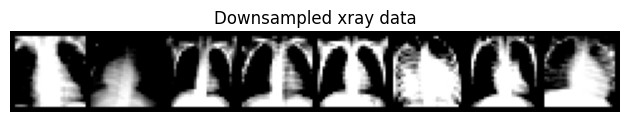

In [30]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders_real_100pct['train']))

# Select 8 images
inputs = inputs[:8]
classes = classes[:8]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

viz.imshow(out, 0, 1, title="Downsampled xray data", save_path=f"{results_folder}/plots/downsampled_xray_data.png")

## Baseline (100 percent real, no data augmentation, no oversampling)
Train the model (e.g., ResNet-18) from scratch (i.e., random initialization of the model parameters) using the training X-ray images.

In [18]:
from src import train_clf

# Use same hyperparameters for all models

In [19]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [20]:
lr = 0.001
momentum = 0.9
num_epochs = 20
step_size = 7
gamma = 0.1

n_outputs = 2

### Scratch: baseline, no augmentation/data balancing, full amount of data
Train the model on real data only

In [21]:
model_real_100pct = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct.fc.in_features
model_real_100pct.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_real_100pct = optim.SGD(model_real_100pct.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_100pct = lr_scheduler.StepLR(optimizer_real_100pct, step_size=step_size, gamma=gamma)

In [22]:
model_real_100pct, hist_real_100pct = train_clf.train_model(
    model_real_100pct, criterion, optimizer_real_100pct, exp_lr_scheduler_real_100pct,
    dataloaders_real_100pct, dataset_sizes_real_100pct, results_folder, model_name="real_100pct", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.2103; acc: 0.9178
Phase:  val
val loss: 0.1163; acc: 0.9542

Epoch 2/20
----------
Phase:  train
train loss: 0.1015; acc: 0.9618
Phase:  val
val loss: 0.1062; acc: 0.9570

Epoch 3/20
----------
Phase:  train
train loss: 0.0562; acc: 0.9804
Phase:  val
val loss: 0.0920; acc: 0.9647

Epoch 4/20
----------
Phase:  train
train loss: 0.0583; acc: 0.9816
Phase:  val
val loss: 0.0804; acc: 0.9733

Epoch 5/20
----------
Phase:  train
train loss: 0.0353; acc: 0.9866
Phase:  val
val loss: 0.0876; acc: 0.9656

Epoch 6/20
----------
Phase:  train
train loss: 0.0232; acc: 0.9909
Phase:  val
val loss: 0.0905; acc: 0.9713

Epoch 7/20
----------
Phase:  train
train loss: 0.0201; acc: 0.9935
Phase:  val
val loss: 0.0967; acc: 0.9656

Epoch 8/20
----------
Phase:  train
train loss: 0.0152; acc: 0.9959
Phase:  val
val loss: 0.0914; acc: 0.9694

Epoch 9/20
----------
Phase:  train
train loss: 0.0113; acc: 0.9974
Phase:  val
val loss: 0.0920; acc: 0.9694

E

In [27]:
train_loss_real_100pct, train_acc_real_100pct, val_loss_real_100pct, val_acc_real_100pct = hist_real_100pct

#### Analyze baseline scratch model performance

In [28]:
train_loss_real_100pct, train_acc_real_100pct, val_loss_real_100pct, val_acc_real_100pct = train_clf.load_training_metrics(f"{results_folder}/metrics/real_100pct.npz")

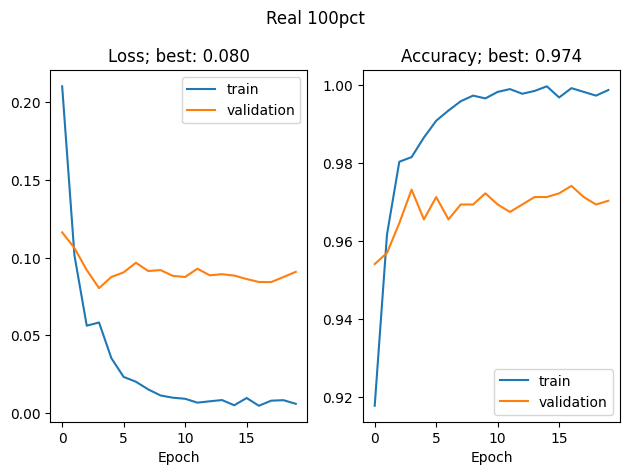

In [29]:
viz.plot_training_metrics(train_loss_real_100pct, train_acc_real_100pct, val_loss_real_100pct, val_acc_real_100pct, title="Real 100pct", save_dir=f"{results_folder}/plots")

#### Evaluate model on test set

In [31]:
# Load model
model_real_100pct = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct.fc.in_features
model_real_100pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_100pct.load_state_dict(torch.load(f'{results_folder}/models/real_100pct.pth'))

<All keys matched successfully>

In [34]:
y_true_real_100pct, y_pred_real_100pct, test_accuracy_real_100pct, per_class_acc_real_100pct = train_clf.evaluate_model_on_test_set(model_real_100pct, data_loader=dataloaders_real_100pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 58.5 %
Accuracy for class: PNEUMONIA is 97.2 %
Overall accuracy (Real 100pct): 82.7
Precision: 0.861
Recall: 0.779
F1 score: 0.796


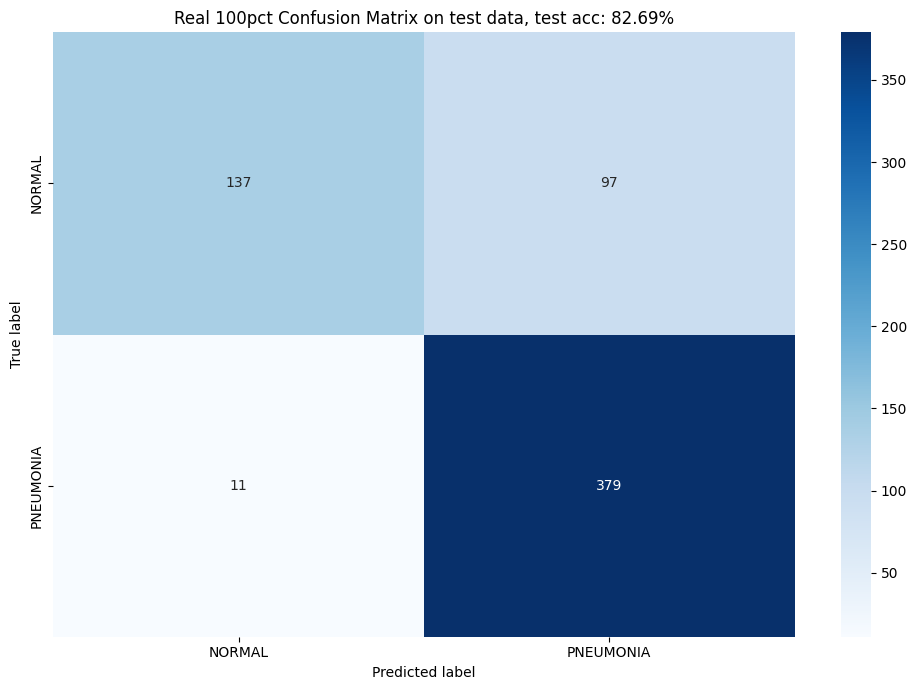

In [35]:
confusion_real_100pct, precision_real_100pct, recall_real_100pct, fscore_real_100pct, _ = train_clf.compute_metrics_on_test_set(y_true_real_100pct, y_pred_real_100pct)
viz.show_test_summary_metrics(
    test_accuracy_real_100pct, per_class_acc_real_100pct, confusion_real_100pct, precision_real_100pct, recall_real_100pct, fscore_real_100pct,
    "Real 100pct", class_names, save_dir=f"{results_folder}/plots")

## Scratch, use 10% of training data

In [36]:
full_train_set = dataloaders_real_100pct['train'].dataset
# Sample 10% of the data from the full training set
train_set_10pct = torch.utils.data.Subset(full_train_set, torch.randperm(len(full_train_set))[:int(len(full_train_set)*0.1)])
# Create a new dataloader for the 10% training set
train_dataloader_10pct = torch.utils.data.DataLoader(train_set_10pct, batch_size=batch_size, shuffle=True, num_workers=4)

In [37]:
len(train_dataloader_10pct.dataset), len(dataloaders_real_100pct['train'].dataset)

(418, 4185)

In [38]:
dataloaders_10pct_train = {
    'train': train_dataloader_10pct,
    'val': dataloaders_real_100pct['val'],
    'test': dataloaders_real_100pct['test']
}
dataset_sizes_10pct_train = {
    'train': len(train_dataloader_10pct.dataset),
    'val': len(dataloaders_real_100pct['val'].dataset),
    'test': len(dataloaders_real_100pct['test'].dataset)
}

In [39]:
dataset_sizes_10pct_train

{'train': 418, 'val': 1047, 'test': 624}

In [40]:
model_real_10pct = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct.fc.in_features
model_real_10pct.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_real_10pct = optim.SGD(model_real_10pct.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_10pct = lr_scheduler.StepLR(optimizer_real_10pct, step_size=step_size, gamma=gamma)

In [41]:
model_real_10pct, hist_real_10pct = train_clf.train_model(
    model_real_10pct, criterion, optimizer_real_10pct, exp_lr_scheduler_real_10pct,
    dataloaders_10pct_train, dataset_sizes_10pct_train, results_folder, model_name="real_10pct", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5364; acc: 0.7344
Phase:  val
val loss: 0.3955; acc: 0.8797

Epoch 2/20
----------
Phase:  train
train loss: 0.2300; acc: 0.9019
Phase:  val
val loss: 0.2597; acc: 0.8911

Epoch 3/20
----------
Phase:  train
train loss: 0.1563; acc: 0.9426
Phase:  val
val loss: 0.2987; acc: 0.9016

Epoch 4/20
----------
Phase:  train
train loss: 0.3577; acc: 0.8684
Phase:  val
val loss: 0.3938; acc: 0.8204

Epoch 5/20
----------
Phase:  train
train loss: 0.2078; acc: 0.9163
Phase:  val
val loss: 0.3059; acc: 0.8558

Epoch 6/20
----------
Phase:  train
train loss: 0.1173; acc: 0.9569
Phase:  val
val loss: 0.2668; acc: 0.8959

Epoch 7/20
----------
Phase:  train
train loss: 0.1593; acc: 0.9258
Phase:  val
val loss: 0.6124; acc: 0.8128

Epoch 8/20
----------
Phase:  train
train loss: 0.1509; acc: 0.9474
Phase:  val
val loss: 0.2858; acc: 0.8844

Epoch 9/20
----------
Phase:  train
train loss: 0.1114; acc: 0.9665
Phase:  val
val loss: 0.2175; acc: 0.9198

E

In [42]:
train_loss_real_10pct, train_acc_real_10pct, val_loss_real_10pct, val_acc_real_10pct = hist_real_10pct

#### Analyze baseline scratch model performance

In [43]:
train_loss_real_10pct, train_acc_real_10pct, val_loss_real_10pct, val_acc_real_10pct = train_clf.load_training_metrics(f"{results_folder}/metrics/real_10pct.npz")

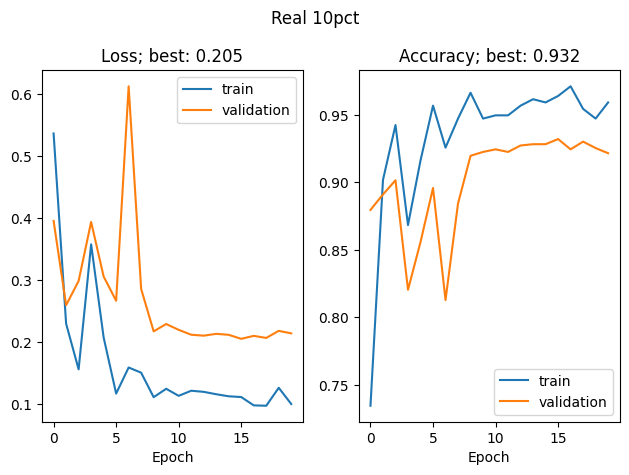

In [44]:
viz.plot_training_metrics(train_loss_real_10pct, train_acc_real_10pct, val_loss_real_10pct, val_acc_real_10pct, title="Real 10pct", save_dir=f"{results_folder}/plots")

#### Evaluate model on test set

In [45]:
# Load model
model_real_10pct = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct.fc.in_features
model_real_10pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_10pct.load_state_dict(torch.load(f'{results_folder}/models/real_10pct.pth'))

<All keys matched successfully>

In [48]:
y_true_real_10pct, y_pred_real_10pct, test_accuracy_real_10pct, per_class_acc_real_10pct = train_clf.evaluate_model_on_test_set(model_real_10pct, data_loader=dataloaders_10pct_train['test'], class_names=class_names)

Accuracy for class: NORMAL is 55.1 %
Accuracy for class: PNEUMONIA is 90.3 %
Overall accuracy (Real 10pct): 77.1
Precision: 0.771
Recall: 0.727
F1 score: 0.737


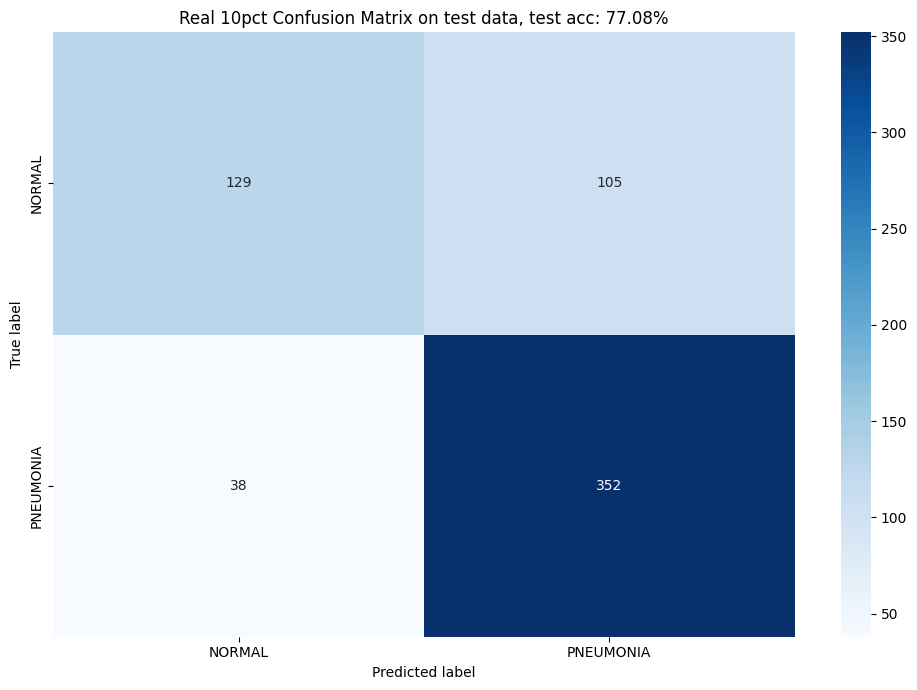

In [49]:
confusion_real_10pct, precision_real_10pct, recall_real_10pct, fscore_real_10pct, _ = train_clf.compute_metrics_on_test_set(y_true_real_10pct, y_pred_real_10pct)
viz.show_test_summary_metrics(
    test_accuracy_real_10pct, per_class_acc_real_10pct, confusion_real_10pct, precision_real_10pct, recall_real_10pct, fscore_real_10pct,
    "Real 10pct", class_names, save_dir=f"{results_folder}/plots")

## Use 100% synthetic data, no augmentation

In [86]:
dataloaders_all_synthetic, dataset_sizes_all_synthetic, _ = dataset.load_diffusion_normalized_xray_data(data_dir_synth, data_dir_real, with_augmentation=False, batch_size=batch_size)

In [87]:
dataset_sizes_all_synthetic

{'train': 5010, 'val': 1047, 'test': 624}

In [72]:
model_all_synthetic = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic.fc.in_features
model_all_synthetic.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_all_synthetic = optim.SGD(model_all_synthetic.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_all_synthetic = lr_scheduler.StepLR(optimizer_all_synthetic, step_size=step_size, gamma=gamma)

In [73]:
model_all_synthetic, hist_all_synthetic = train_clf.train_model(
    model_all_synthetic, criterion, optimizer_all_synthetic, exp_lr_scheduler_all_synthetic,
    dataloaders_all_synthetic, dataset_sizes_all_synthetic, results_folder, model_name="all_synthetic", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.3353; acc: 0.8633
Phase:  val
val loss: 0.3890; acc: 0.8281

Epoch 2/20
----------
Phase:  train
train loss: 0.2137; acc: 0.9090
Phase:  val
val loss: 0.4333; acc: 0.7755

Epoch 3/20
----------
Phase:  train
train loss: 0.1749; acc: 0.9277
Phase:  val
val loss: 0.3912; acc: 0.8147

Epoch 4/20
----------
Phase:  train
train loss: 0.1442; acc: 0.9409
Phase:  val
val loss: 0.3871; acc: 0.8290

Epoch 5/20
----------
Phase:  train
train loss: 0.1322; acc: 0.9439
Phase:  val
val loss: 0.3547; acc: 0.8443

Epoch 6/20
----------
Phase:  train
train loss: 0.1170; acc: 0.9515
Phase:  val
val loss: 0.3578; acc: 0.8443

Epoch 7/20
----------
Phase:  train
train loss: 0.0990; acc: 0.9563
Phase:  val
val loss: 0.5452; acc: 0.8128

Epoch 8/20
----------
Phase:  train
train loss: 0.0631; acc: 0.9776
Phase:  val
val loss: 0.4908; acc: 0.8233

Epoch 9/20
----------
Phase:  train
train loss: 0.0529; acc: 0.9832
Phase:  val
val loss: 0.4536; acc: 0.8319

E

In [97]:
train_loss_all_synthetic, train_acc_all_synthetic, val_loss_all_synthetic, val_acc_all_synthetic = hist_all_synthetic

#### Analyze baseline scratch model performance

In [98]:
train_loss_all_synthetic, train_acc_all_synthetic, val_loss_all_synthetic, val_acc_all_synthetic = train_clf.load_training_metrics(f"{results_folder}/metrics/all_synthetic.npz")

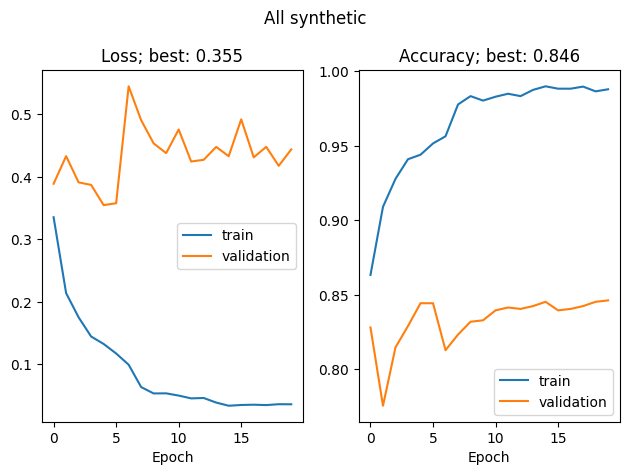

In [99]:
viz.plot_training_metrics(train_loss_all_synthetic, train_acc_all_synthetic, val_loss_all_synthetic, val_acc_all_synthetic, title="All synthetic", save_dir=f"{results_folder}/plots")

#### Evaluate model on test set

In [100]:
# Load model
model_all_synthetic = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic.fc.in_features
model_all_synthetic.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_all_synthetic.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

<All keys matched successfully>

In [101]:
y_true_all_synthetic, y_pred_all_synthetic, test_accuracy_all_synthetic, per_class_acc_all_synthetic = train_clf.evaluate_model_on_test_set(model_all_synthetic, data_loader=dataloaders_all_synthetic['test'], class_names=class_names)

Accuracy for class: PNEUMONIA is 71.8 %
Accuracy for class: NORMAL is 75.6 %
Overall accuracy (All synthetic): 73.2
Precision: 0.724
Recall: 0.737
F1 score: 0.725


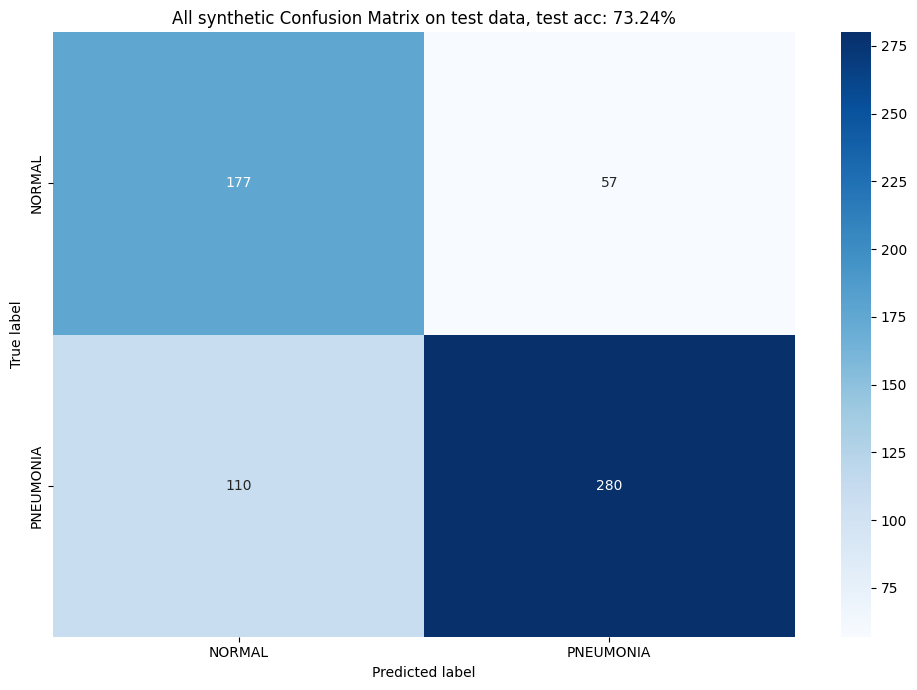

In [102]:
confusion_all_synthetic, precision_all_synthetic, recall_all_synthetic, fscore_all_synthetic, _ = train_clf.compute_metrics_on_test_set(y_true_all_synthetic, y_pred_all_synthetic)
viz.show_test_summary_metrics(
    test_accuracy_all_synthetic, per_class_acc_all_synthetic, confusion_all_synthetic, precision_all_synthetic, recall_all_synthetic, fscore_all_synthetic,
    "All synthetic", class_names, save_dir=f"{results_folder}/plots")

## Use 100% synthetic data, with augmentation

In [84]:
dataloaders_all_synthetic_w_aug, dataset_sizes_all_synthetic_w_aug, _ = dataset.load_diffusion_normalized_xray_data(data_dir_synth, data_dir_real, with_augmentation=True, batch_size=batch_size)

In [85]:
dataset_sizes_all_synthetic_w_aug

{'train': 5010, 'val': 1047, 'test': 624}

In [88]:
model_all_synthetic_w_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic_w_aug.fc.in_features
model_all_synthetic_w_aug.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_all_synthetic_w_aug = optim.SGD(model_all_synthetic_w_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_all_synthetic_w_aug = lr_scheduler.StepLR(optimizer_all_synthetic_w_aug, step_size=step_size, gamma=gamma)

In [89]:
model_all_synthetic_w_aug, hist_all_synthetic_w_aug = train_clf.train_model(
    model_all_synthetic_w_aug, criterion, optimizer_all_synthetic_w_aug, exp_lr_scheduler_all_synthetic_w_aug,
    dataloaders_all_synthetic_w_aug, dataset_sizes_all_synthetic_w_aug, results_folder, model_name="all_synthetic_w_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.3951; acc: 0.8265
Phase:  val
val loss: 0.4776; acc: 0.7870

Epoch 2/20
----------
Phase:  train
train loss: 0.3013; acc: 0.8709
Phase:  val
val loss: 0.4195; acc: 0.7975

Epoch 3/20
----------
Phase:  train
train loss: 0.2796; acc: 0.8808
Phase:  val
val loss: 0.3858; acc: 0.8395

Epoch 4/20
----------
Phase:  train
train loss: 0.2692; acc: 0.8858
Phase:  val
val loss: 0.3444; acc: 0.8940

Epoch 5/20
----------
Phase:  train
train loss: 0.2653; acc: 0.8888
Phase:  val
val loss: 0.3675; acc: 0.8319

Epoch 6/20
----------
Phase:  train
train loss: 0.2443; acc: 0.9004
Phase:  val
val loss: 0.3537; acc: 0.8644

Epoch 7/20
----------
Phase:  train
train loss: 0.2518; acc: 0.8956
Phase:  val
val loss: 0.3315; acc: 0.8758

Epoch 8/20
----------
Phase:  train
train loss: 0.2439; acc: 0.8966
Phase:  val
val loss: 0.3496; acc: 0.8825

Epoch 9/20
----------
Phase:  train
train loss: 0.2352; acc: 0.8976
Phase:  val
val loss: 0.3427; acc: 0.8768

E

In [91]:
train_loss_all_synthetic_w_aug, train_acc_all_synthetic_w_aug, val_loss_all_synthetic_w_aug, val_acc_all_synthetic_w_aug = hist_all_synthetic_w_aug

#### Analyze synthetic with aug model performance

In [92]:
train_loss_all_synthetic_w_aug, train_acc_all_synthetic_w_aug, val_loss_all_synthetic_w_aug, val_acc_all_synthetic_w_aug = train_clf.load_training_metrics(f"{results_folder}/metrics/all_synthetic_w_aug.npz")

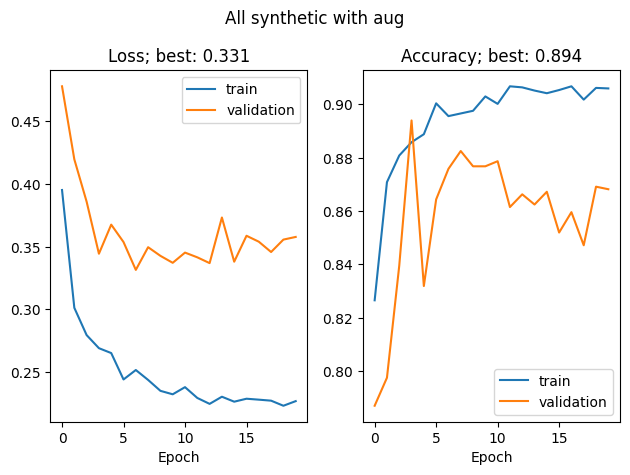

In [93]:
viz.plot_training_metrics(train_loss_all_synthetic_w_aug, train_acc_all_synthetic_w_aug, val_loss_all_synthetic_w_aug, val_acc_all_synthetic_w_aug, title="All synthetic with aug", save_dir=f"{results_folder}/plots")

#### Evaluate model on test set

In [108]:
# Load model
model_all_synthetic_w_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic_w_aug.fc.in_features
model_all_synthetic_w_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_all_synthetic_w_aug.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic_w_aug.pth'))

<All keys matched successfully>

In [109]:
y_true_all_synthetic_w_aug, y_pred_all_synthetic_w_aug, test_accuracy_all_synthetic_w_aug, per_class_acc_all_synthetic_w_aug = train_clf.evaluate_model_on_test_set(model_all_synthetic_w_aug, data_loader=dataloaders_all_synthetic_w_aug['test'], class_names=class_names)

Accuracy for class: PNEUMONIA is 63.6 %
Accuracy for class: NORMAL is 82.5 %
Overall accuracy (All synthetic with aug): 70.7
Precision: 0.717
Recall: 0.730
F1 score: 0.704


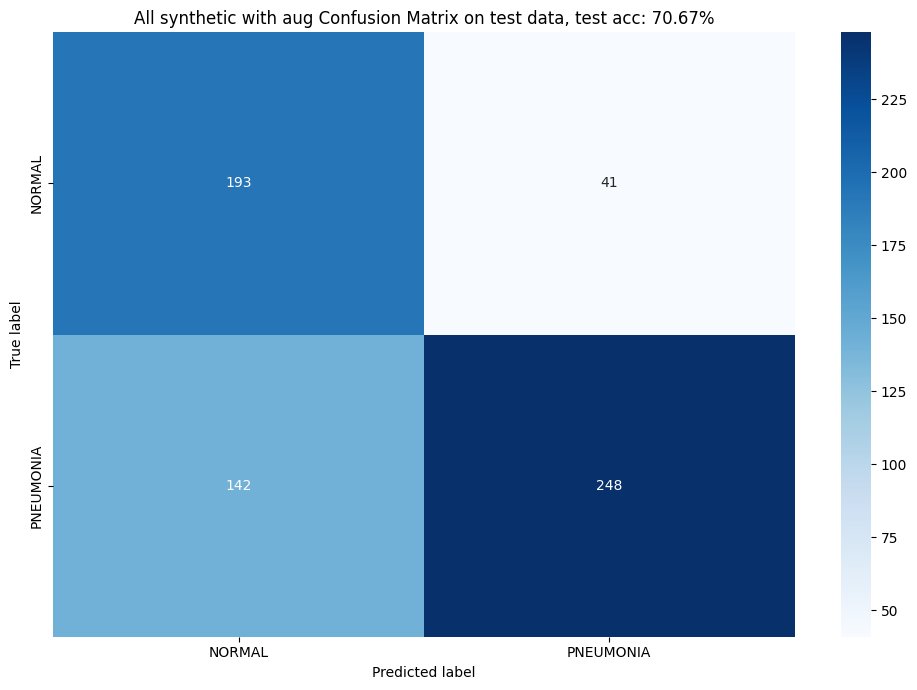

In [110]:
confusion_all_synthetic_w_aug, precision_all_synthetic_w_aug, recall_all_synthetic_w_aug, fscore_all_synthetic_w_aug, _ = train_clf.compute_metrics_on_test_set(y_true_all_synthetic_w_aug, y_pred_all_synthetic_w_aug)
viz.show_test_summary_metrics(
    test_accuracy_all_synthetic_w_aug, per_class_acc_all_synthetic_w_aug, confusion_all_synthetic_w_aug, precision_all_synthetic_w_aug, recall_all_synthetic_w_aug, fscore_all_synthetic_w_aug,
    "All synthetic with aug", class_names, save_dir=f"{results_folder}/plots")

## Fine tune model trained on diffusion with no aug on 10% of real data

In [113]:
model_synth_ft_real10pct = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct.fc.in_features
model_synth_ft_real10pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_synth_ft_real10pct = optim.SGD(model_synth_ft_real10pct.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler_synth_ft_real10pct = lr_scheduler.StepLR(optimizer_synth_ft_real10pct, step_size=step_size, gamma=gamma)

In [114]:
model_synth_ft_real10pct, hist_synth_ft_real10pct = train_clf.train_model(
    model_synth_ft_real10pct, criterion, optimizer_synth_ft_real10pct, exp_lr_scheduler_synth_ft_real10pct,
    dataloaders_10pct_train, dataset_sizes_10pct_train, results_folder, model_name="synth_ft_real10pct", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.6148; acc: 0.8565
Phase:  val
val loss: 1.5858; acc: 0.7412

Epoch 2/20
----------
Phase:  train
train loss: 0.5141; acc: 0.8325
Phase:  val
val loss: 2.3103; acc: 0.5358

Epoch 3/20
----------
Phase:  train
train loss: 0.3168; acc: 0.8756
Phase:  val
val loss: 1.0245; acc: 0.6791

Epoch 4/20
----------
Phase:  train
train loss: 0.2383; acc: 0.8923
Phase:  val
val loss: 0.5970; acc: 0.8223

Epoch 5/20
----------
Phase:  train
train loss: 0.2318; acc: 0.9282
Phase:  val
val loss: 0.4220; acc: 0.8434

Epoch 6/20
----------
Phase:  train
train loss: 0.2780; acc: 0.8876
Phase:  val
val loss: 0.4146; acc: 0.8491

Epoch 7/20
----------
Phase:  train
train loss: 0.1834; acc: 0.9234
Phase:  val
val loss: 0.3682; acc: 0.8634

Epoch 8/20
----------
Phase:  train
train loss: 0.1317; acc: 0.9498
Phase:  val
val loss: 0.2648; acc: 0.9054

Epoch 9/20
----------
Phase:  train
train loss: 0.1374; acc: 0.9474
Phase:  val
val loss: 0.2517; acc: 0.9054

E

In [115]:
train_loss_synth_ft_real10pct, train_acc_synth_ft_real10pct, val_loss_synth_ft_real10pct, val_acc_synth_ft_real10pct = hist_synth_ft_real10pct

#### Analyze synthetic with aug model performance

In [116]:
train_loss_synth_ft_real10pct, train_acc_synth_ft_real10pct, val_loss_synth_ft_real10pct, val_acc_synth_ft_real10pct = train_clf.load_training_metrics(f"{results_folder}/metrics/synth_ft_real10pct.npz")

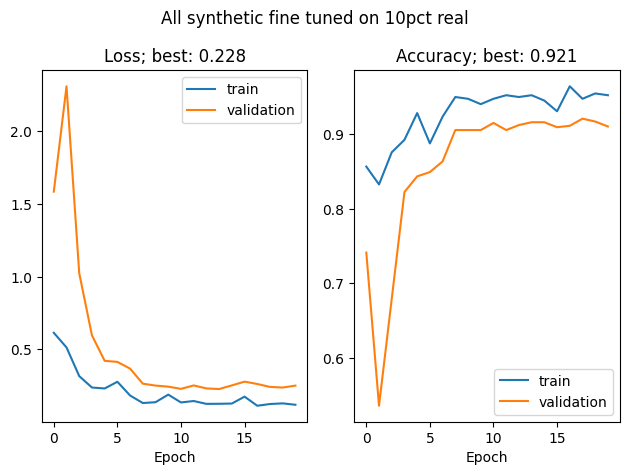

In [120]:
viz.plot_training_metrics(train_loss_synth_ft_real10pct, train_acc_synth_ft_real10pct, val_loss_synth_ft_real10pct, val_acc_synth_ft_real10pct, title="All synthetic fine tuned on 10pct real", save_dir=f"{results_folder}/plots")

#### Evaluate model on test set

In [118]:
# Load model
model_synth_ft_real10pct = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct.fc.in_features
model_synth_ft_real10pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real10pct.pth'))

<All keys matched successfully>

In [119]:
y_true_synth_ft_real10pct, y_pred_synth_ft_real10pct, test_accuracy_synth_ft_real10pct, per_class_acc_synth_ft_real10pct = train_clf.evaluate_model_on_test_set(model_synth_ft_real10pct, data_loader=dataloaders_10pct_train['test'], class_names=class_names)

Accuracy for class: NORMAL is 64.1 %
Accuracy for class: PNEUMONIA is 90.0 %
Overall accuracy (All synthetic fine tuned on 10pct real): 80.3
Precision: 0.800
Recall: 0.771
F1 score: 0.780


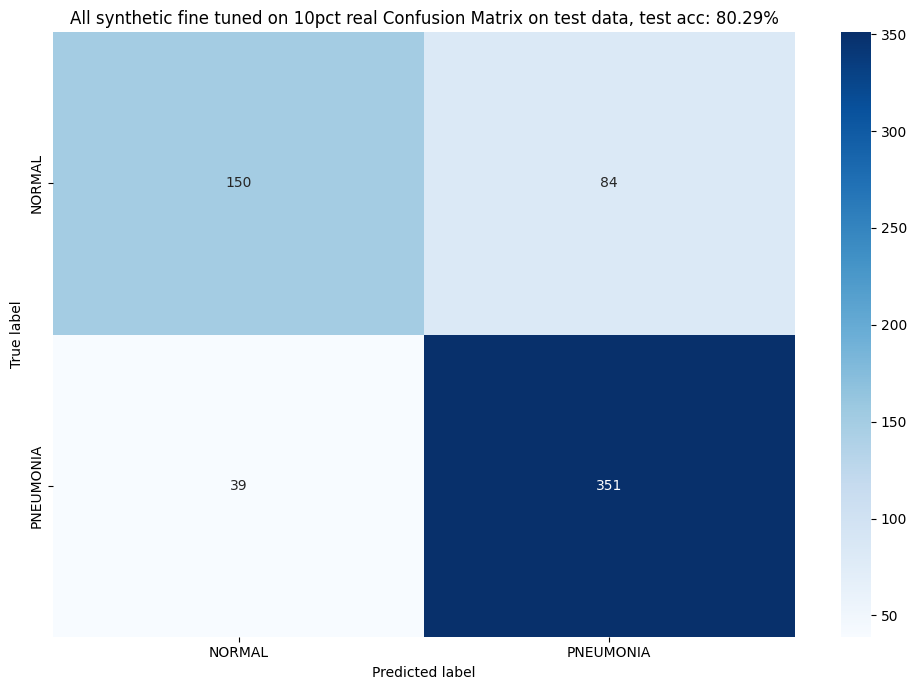

In [122]:
confusion_synth_ft_real10pct, precision_synth_ft_real10pct, recall_synth_ft_real10pct, fscore_synth_ft_real10pct, _ = train_clf.compute_metrics_on_test_set(y_true_synth_ft_real10pct, y_pred_synth_ft_real10pct)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real10pct, per_class_acc_synth_ft_real10pct, confusion_synth_ft_real10pct, precision_synth_ft_real10pct, recall_synth_ft_real10pct, fscore_synth_ft_real10pct,
    "All synthetic fine tuned on 10pct real", class_names, save_dir=f"{results_folder}/plots")

# Oversampling

In [16]:
labels = dataset.get_labels(dataloaders['train'])

In [21]:
class_weights = dataset.compute_class_weights(labels).to(device)
class_weights

tensor([0.7474, 0.2526], device='cuda:0')

We see that the weight for normal is higher because there are fewer instances of the normal class in the dataset.

In [22]:
model_scratch_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_weighted.fc.in_features
model_scratch_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
# Observe that all parameters are being optimized
optimizer_scratch_weighted = optim.SGD(model_scratch_weighted.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_scratch_weighted = lr_scheduler.StepLR(optimizer_scratch_weighted, step_size=7, gamma=0.1)

In [23]:
model_scratch_weighted, hist_scratch_weighted = train.train_model(
    model_scratch_weighted, criterion_weighted, optimizer_scratch_weighted,
    exp_lr_scheduler_scratch_weighted, dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
Phase:  train
train loss: 0.6274; acc: 0.7467
Phase:  val
val loss: 0.5498; acc: 0.7937

Epoch 2/20
----------
Phase:  train
train loss: 0.5453; acc: 0.7766
Phase:  val
val loss: 0.3451; acc: 0.8701

Epoch 3/20
----------
Phase:  train
train loss: 0.4354; acc: 0.8277
Phase:  val
val loss: 0.3034; acc: 0.8854

Epoch 4/20
----------
Phase:  train
train loss: 0.4311; acc: 0.8318
Phase:  val
val loss: 0.3001; acc: 0.8749

Epoch 5/20
----------
Phase:  train
train loss: 0.3854; acc: 0.8447
Phase:  val
val loss: 0.3211; acc: 0.8777

Epoch 6/20
----------
Phase:  train
train loss: 0.3578; acc: 0.8652
Phase:  val
val loss: 0.2699; acc: 0.9093

Epoch 7/20
----------
Phase:  train
train loss: 0.3361; acc: 0.8655
Phase:  val
val loss: 0.3781; acc: 0.8873

Epoch 8/20
----------
Phase:  train
train loss: 0.2717; acc: 0.8965
Phase:  val
val loss: 0.2389; acc: 0.9102

Epoch 9/20
----------
Phase:  train
train loss: 0.2647; acc: 0.8987
Phase:  val
val loss: 0.2373; acc: 0.9198

E

In [24]:
train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted = hist_scratch_weighted
train.save_training_metrics("metrics/scratch_weighted", train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted)

#### Analyze scratch weighted loss model performance

In [165]:
train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted = train.load_training_metrics("metrics/scratch_weighted.npz")

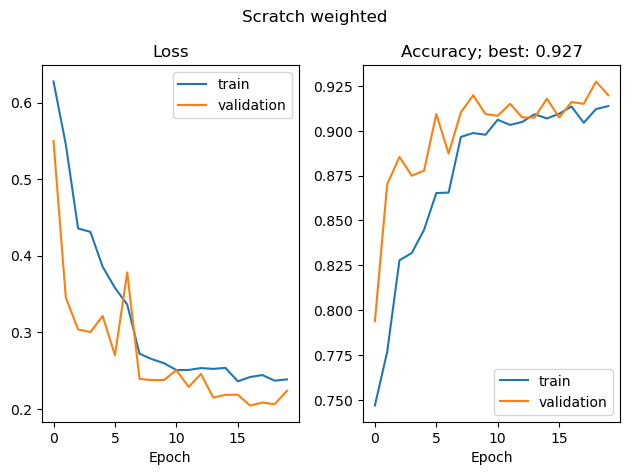

In [166]:
viz.plot_training_metrics(train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted, title="Scratch weighted")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

Save model

In [26]:
# Save model
torch.save(model_scratch_weighted.state_dict(), 'models/scratch_weighted.pth')

#### Evaluate model on test set

In [29]:
# Load model
model_scratch_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_weighted.fc.in_features
model_scratch_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_scratch_weighted.load_state_dict(torch.load('models/scratch_weighted.pth'))

<All keys matched successfully>

In [70]:
y_true_scratch_weighted, y_pred_scratch_weighted, test_accuracy_scratch_weighted, per_class_acc_scratch_weighted = train.evaluate_model_on_test_set(model_scratch_weighted, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 76.9 %
Accuracy for class: PNEUMONIA is 97.9 %
Overall accuracy (Scratch weighted): 90.1
Precision: 0.917
Recall: 0.874
F1 score: 0.889


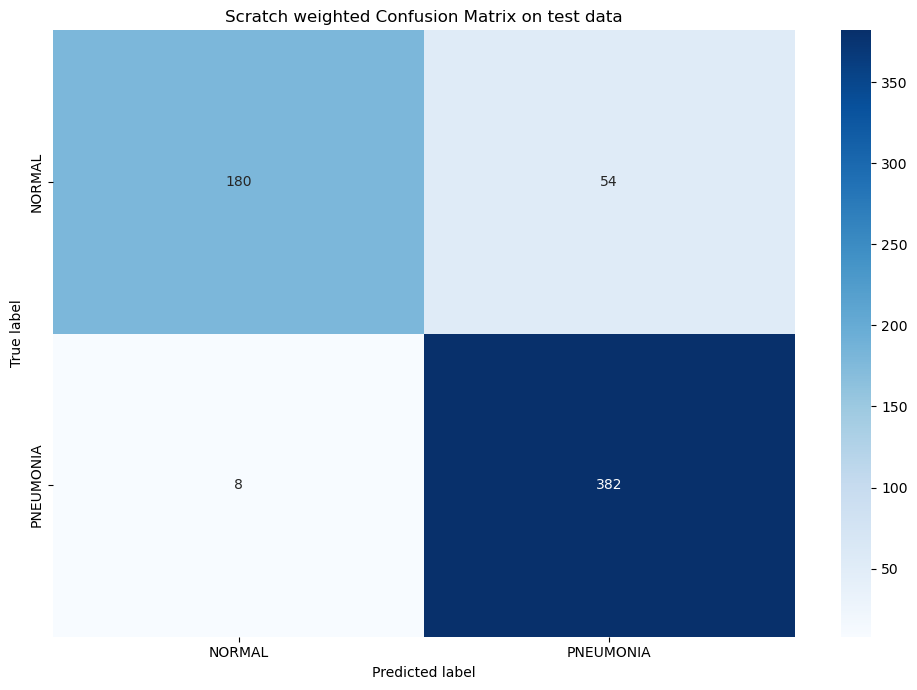

In [168]:
confusion_scratch_weighted, precision_scratch_weighted, recall_scratch_weighted, fscore_scratch_weighted, _ = train.compute_metrics_on_test_set(y_true_scratch_weighted, y_pred_scratch_weighted)
viz.show_test_summary_metrics(
    test_accuracy_scratch_weighted, per_class_acc_scratch_weighted, confusion_scratch_weighted, precision_scratch_weighted, recall_scratch_weighted, fscore_scratch_weighted,
    "Scratch weighted", class_names)

### Scratch: cutmix as data augmentation

In [76]:
model_scratch_cutmix = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_cutmix.fc.in_features
model_scratch_cutmix.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_scratch_cutmix = optim.SGD(model_scratch_cutmix.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_scratch_cutmix = lr_scheduler.StepLR(optimizer_scratch_cutmix, step_size=7, gamma=0.1)

In [79]:
model_scratch_cutmix, hist_scratch_cutmix = train.train_model(
    model_scratch_cutmix, criterion, optimizer_scratch_cutmix, exp_lr_scheduler_scratch_cutmix,
    dataloaders, dataset_sizes, num_epochs=20, use_cutmix=True)

Epoch 1/20
----------
Phase:  train
train loss: 0.5456; acc: 0.7584
Phase:  val
val loss: 0.3225; acc: 0.8510

Epoch 2/20
----------
Phase:  train
train loss: 0.4992; acc: 0.7790
Phase:  val
val loss: 0.3756; acc: 0.8357

Epoch 3/20
----------
Phase:  train
train loss: 0.4526; acc: 0.8033
Phase:  val
val loss: 0.3341; acc: 0.8453

Epoch 4/20
----------
Phase:  train
train loss: 0.4304; acc: 0.8136
Phase:  val
val loss: 0.2877; acc: 0.8730

Epoch 5/20
----------
Phase:  train
train loss: 0.4156; acc: 0.8182
Phase:  val
val loss: 0.2538; acc: 0.8997

Epoch 6/20
----------
Phase:  train
train loss: 0.3947; acc: 0.8284
Phase:  val
val loss: 0.2548; acc: 0.8959

Epoch 7/20
----------
Phase:  train
train loss: 0.3647; acc: 0.8495
Phase:  val
val loss: 0.2460; acc: 0.8921

Epoch 8/20
----------
Phase:  train
train loss: 0.3080; acc: 0.8714
Phase:  val
val loss: 0.2220; acc: 0.9054

Epoch 9/20
----------
Phase:  train
train loss: 0.3157; acc: 0.8645
Phase:  val
val loss: 0.2323; acc: 0.9045

E

Save metrics

In [80]:
train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix = hist_scratch_cutmix
train.save_training_metrics("metrics/scratch_cutmix", train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix)

Save model

In [105]:
# Save model
torch.save(model_scratch_cutmix.state_dict(), 'models/scratch_cutmix.pth')

#### Analyze scratch cutmix model performance

In [169]:
train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix = train.load_training_metrics("metrics/scratch_cutmix.npz")

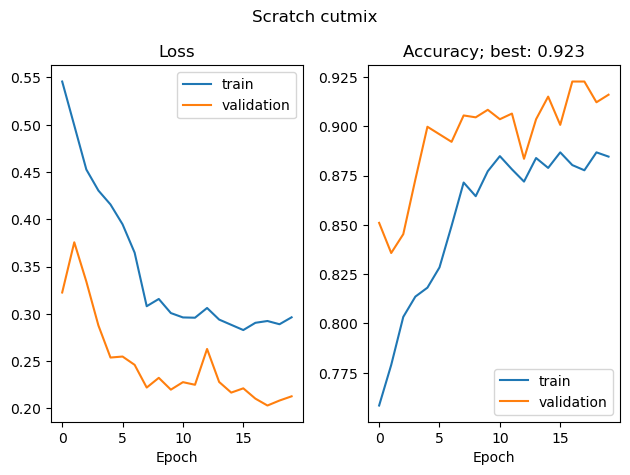

In [170]:
viz.plot_training_metrics(train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix, title="Scratch cutmix")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

#### Evaluate model on test set

In [30]:
# Load model
model_scratch_cutmix = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_cutmix.fc.in_features
model_scratch_cutmix.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_scratch_cutmix.load_state_dict(torch.load('models/scratch_cutmix.pth'))

<All keys matched successfully>

In [111]:
y_true_scratch_cutmix, y_pred_scratch_cutmix, test_accuracy_scratch_cutmix, per_class_acc_scratch_cutmix = train.evaluate_model_on_test_set(model_scratch_cutmix, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 79.9 %
Accuracy for class: PNEUMONIA is 96.9 %
Overall accuracy (Scratch cutmix): 90.5
Precision: 0.915
Recall: 0.884
F1 score: 0.896


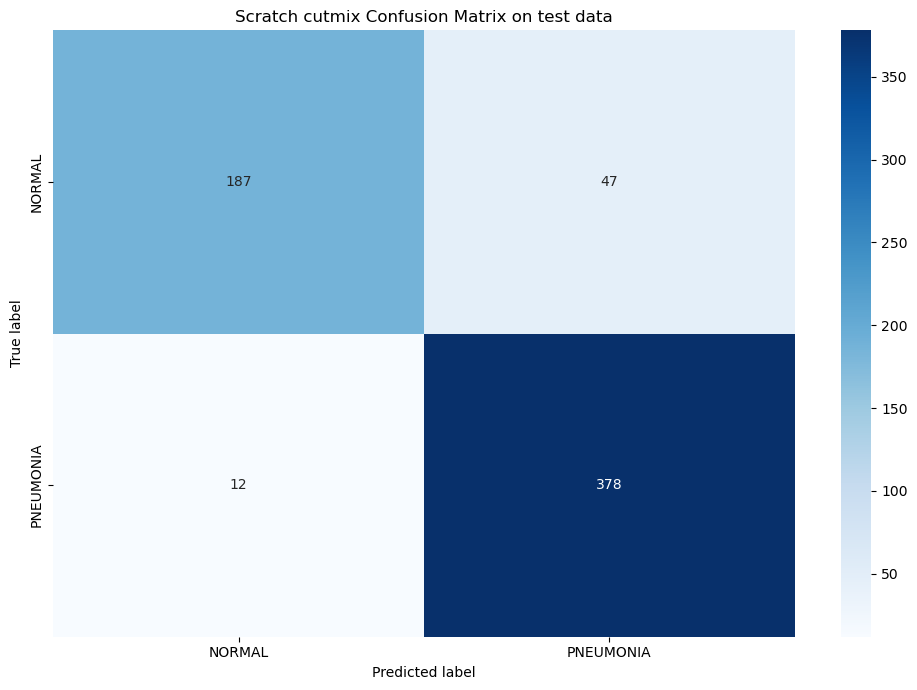

In [171]:
confusion_scratch_cutmix, precision_scratch_cutmix, recall_scratch_cutmix, fscore_scratch_cutmix, _ = train.compute_metrics_on_test_set(y_true_scratch_cutmix, y_pred_scratch_cutmix)
viz.show_test_summary_metrics(
    test_accuracy_scratch_cutmix, per_class_acc_scratch_cutmix, confusion_scratch_cutmix, precision_scratch_cutmix, recall_scratch_cutmix, fscore_scratch_cutmix,
    "Scratch cutmix", class_names)

### Scratch: cutmix and weighted loss

In [113]:
class_weights

tensor([0.7474, 0.2526], device='cuda:0')

In [114]:
model_scratch_cutmix_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_cutmix_weighted.fc.in_features
model_scratch_cutmix_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
# Observe that all parameters are being optimized
optimizer_scratch_cutmix_weighted = optim.SGD(model_scratch_cutmix_weighted.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_scratch_cutmix_weighted = lr_scheduler.StepLR(optimizer_scratch_cutmix_weighted, step_size=7, gamma=0.1)

In [115]:
model_scratch_cutmix_weighted, hist_scratch_cutmix_weighted = train.train_model(
    model_scratch_cutmix_weighted, criterion_weighted, optimizer_scratch_cutmix_weighted, exp_lr_scheduler_scratch_cutmix_weighted,
    dataloaders, dataset_sizes, num_epochs=20, use_cutmix=True)

Epoch 1/20
----------
Phase:  train
train loss: 0.7183; acc: 0.7032
Phase:  val
val loss: 0.4388; acc: 0.7775

Epoch 2/20
----------
Phase:  train
train loss: 0.5898; acc: 0.7501
Phase:  val
val loss: 0.3904; acc: 0.8529

Epoch 3/20
----------
Phase:  train
train loss: 0.5472; acc: 0.7735
Phase:  val
val loss: 0.3607; acc: 0.8510

Epoch 4/20
----------
Phase:  train
train loss: 0.5249; acc: 0.7888
Phase:  val
val loss: 0.7155; acc: 0.8023

Epoch 5/20
----------
Phase:  train
train loss: 0.4992; acc: 0.7976
Phase:  val
val loss: 0.3735; acc: 0.8739

Epoch 6/20
----------
Phase:  train
train loss: 0.4829; acc: 0.8041
Phase:  val
val loss: 0.3057; acc: 0.8625

Epoch 7/20
----------
Phase:  train
train loss: 0.4566; acc: 0.8189
Phase:  val
val loss: 0.2850; acc: 0.8749

Epoch 8/20
----------
Phase:  train
train loss: 0.3798; acc: 0.8550
Phase:  val
val loss: 0.2687; acc: 0.8921

Epoch 9/20
----------
Phase:  train
train loss: 0.3807; acc: 0.8507
Phase:  val
val loss: 0.2637; acc: 0.8959

E

Save metrics

In [116]:
train_loss_scratch_cutmix_weighted, train_acc_scratch_cutmix_weighted, val_loss_scratch_cutmix_weighted, val_acc_scratch_cutmix_weighted = hist_scratch_cutmix_weighted
train.save_training_metrics("metrics/scratch_cutmix_weighted", train_loss_scratch_cutmix_weighted, train_acc_scratch_cutmix_weighted, val_loss_scratch_cutmix_weighted, val_acc_scratch_cutmix_weighted)

Save model

In [117]:
# Save model
torch.save(model_scratch_cutmix_weighted.state_dict(), 'models/scratch_cutmix_weighted.pth')

#### Analyze scratch cutmix model performance

In [210]:
train_loss_scratch_cutmix_weighted, train_acc_scratch_cutmix_weighted, val_loss_scratch_cutmix_weighted, val_acc_scratch_cutmix_weighted = train.load_training_metrics("metrics/scratch_cutmix_weighted.npz")

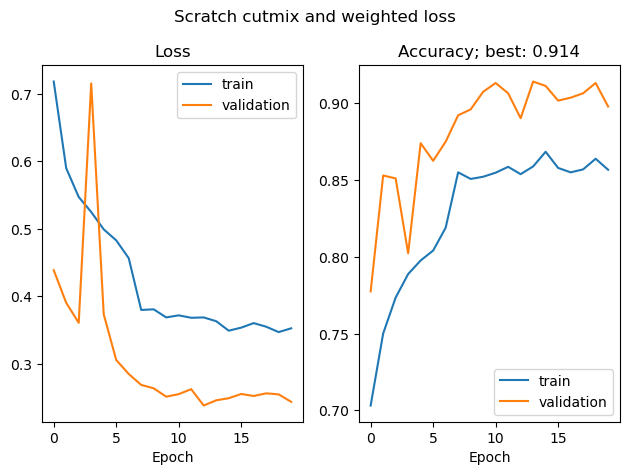

In [211]:
viz.plot_training_metrics(train_loss_scratch_cutmix_weighted, train_acc_scratch_cutmix_weighted, val_loss_scratch_cutmix_weighted, val_acc_scratch_cutmix_weighted, title="Scratch cutmix and weighted loss")

Not sure how good this combination is; since both cross entropy and cutmix modify the loss function computation, maybe need to have two loss functions, one for cutmix and one for normal?

#### Evaluate model on test set

In [31]:
# Load model
model_scratch_cutmix_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_cutmix_weighted.fc.in_features
model_scratch_cutmix_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_scratch_cutmix_weighted.load_state_dict(torch.load('models/scratch_cutmix_weighted.pth'))

<All keys matched successfully>

In [214]:
y_true_scratch_cutmix_weighted, y_pred_scratch_cutmix_weighted, test_accuracy_scratch_cutmix_weighted, per_class_acc_scratch_cutmix_weighted = train.evaluate_model_on_test_set(model_scratch_cutmix_weighted, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 82.5 %
Accuracy for class: PNEUMONIA is 91.3 %
Overall accuracy (scratch cutmix and weighted loss): 88.0
Precision: 0.873
Recall: 0.869
F1 score: 0.871


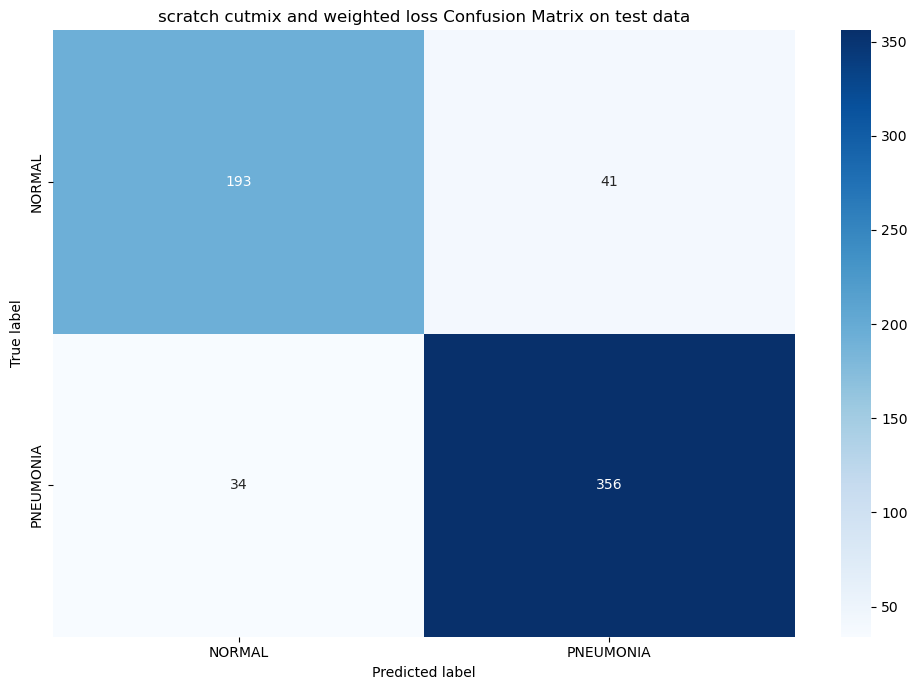

In [215]:
confusion_scratch_cutmix_weighted, precision_scratch_cutmix_weighted, recall_scratch_cutmix_weighted, fscore_scratch_cutmix_weighted, _ = train.compute_metrics_on_test_set(y_true_scratch_cutmix_weighted, y_pred_scratch_cutmix_weighted)
viz.show_test_summary_metrics(
    test_accuracy_scratch_cutmix_weighted, per_class_acc_scratch_cutmix_weighted, confusion_scratch_cutmix_weighted, precision_scratch_cutmix_weighted, recall_scratch_cutmix_weighted, fscore_scratch_cutmix_weighted,
    "scratch cutmix and weighted loss", class_names)

## Task 1.2
Leverage the pre-trained ResNet-18 (the same CNN used in Task 1.1) model on the ImageNet and fine tune the model on the target X-ray images (training set).

### Pretrain: baseline, no augmentation/data balancing
First try training throughout the whole network since we have a lot of data, and the target domain (xray images) is different from the original domain (natural images)

In [32]:
model_ft = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
model_ft, hist_ft = train.train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler_ft,
    dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
Phase:  train
train loss: 0.4105; acc: 0.8397
Phase:  val
val loss: 0.2199; acc: 0.9140

Epoch 2/20
----------
Phase:  train
train loss: 0.2906; acc: 0.8879
Phase:  val
val loss: 0.2837; acc: 0.9064

Epoch 3/20
----------
Phase:  train
train loss: 0.3014; acc: 0.8908
Phase:  val
val loss: 0.1603; acc: 0.9494

Epoch 4/20
----------
Phase:  train
train loss: 0.2391; acc: 0.9104
Phase:  val
val loss: 0.1457; acc: 0.9456

Epoch 5/20
----------
Phase:  train
train loss: 0.2085; acc: 0.9250
Phase:  val
val loss: 0.1782; acc: 0.9398

Epoch 6/20
----------
Phase:  train
train loss: 0.2457; acc: 0.9137
Phase:  val
val loss: 0.1379; acc: 0.9456

Epoch 7/20
----------
Phase:  train
train loss: 0.1895; acc: 0.9345
Phase:  val
val loss: 0.1499; acc: 0.9465

Epoch 8/20
----------
Phase:  train
train loss: 0.1568; acc: 0.9496
Phase:  val
val loss: 0.1218; acc: 0.9522

Epoch 9/20
----------
Phase:  train
train loss: 0.1356; acc: 0.9551
Phase:  val
val loss: 0.1351; acc: 0.9513

E

In [41]:
train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft = hist_ft
train.save_training_metrics("metrics/ft_baseline", train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft)

#### Analyze baseline fine tuned model performance

In [72]:
train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft = train.load_training_metrics("metrics/ft_baseline.npz")

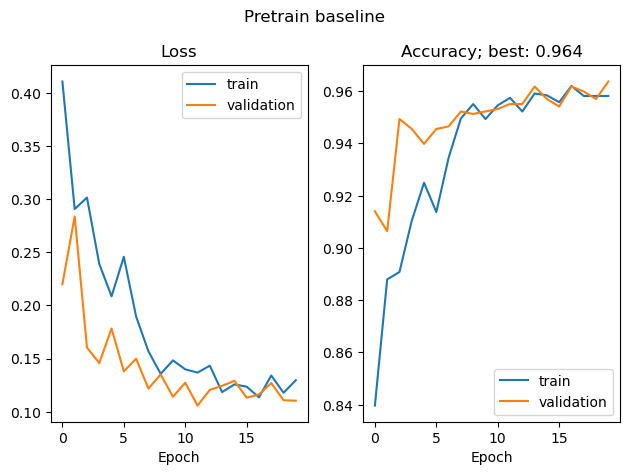

In [178]:
viz.plot_training_metrics(train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft, title="Pretrain baseline")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

Save model

In [37]:
# Save model
torch.save(model_ft.state_dict(), 'models/ft_baseline.pth')

#### Evaluate model on test set

In [32]:
# Load model
model_ft = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_ft.load_state_dict(torch.load('models/ft_baseline.pth'))

<All keys matched successfully>

In [181]:
y_true_ft, y_pred_ft, test_accuracy_ft, per_class_acc_ft = train.evaluate_model_on_test_set(model_ft, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 79.9 %
Accuracy for class: PNEUMONIA is 99.5 %
Overall accuracy (Pretrain baseline): 92.1
Precision: 0.941
Recall: 0.897
F1 score: 0.912


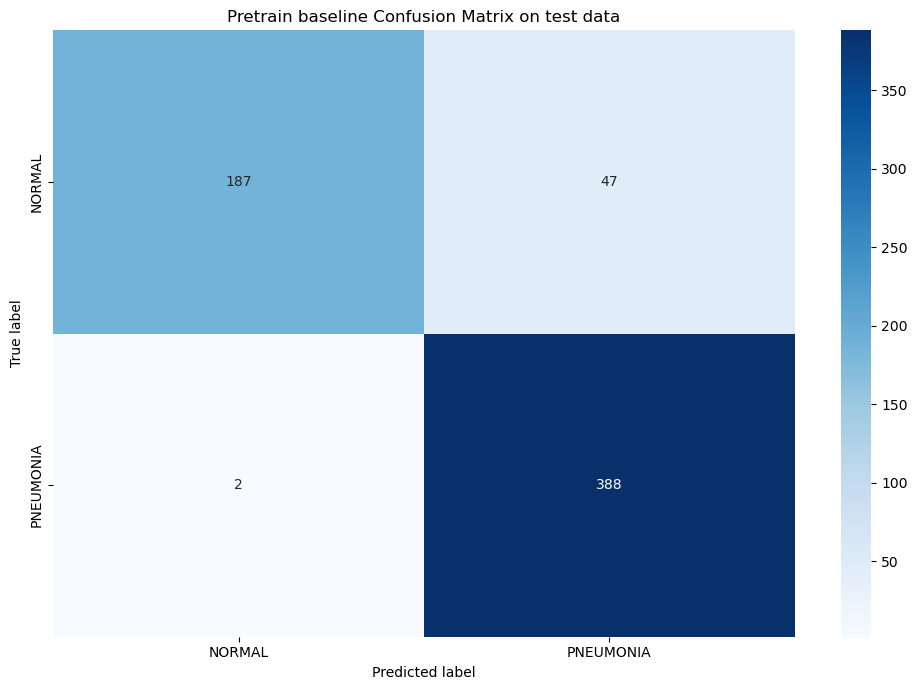

In [182]:
confusion_ft, precision_ft, recall_ft, fscore_ft, _ = train.compute_metrics_on_test_set(y_true_ft, y_pred_ft)
viz.show_test_summary_metrics(test_accuracy_ft, per_class_acc_ft, confusion_ft, precision_ft, recall_ft, fscore_ft, "Pretrain baseline", class_names)

This model seems to be even more affected by the data imbalance; the model predicts even more instances of pneumonia than the baseline model without transfer learning.

### Pretrain: use weighted loss function to address data imbalance

In [33]:
class_weights

tensor([0.7474, 0.2526], device='cuda:0')

In [34]:
model_ft_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_weighted.fc.in_features
model_ft_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
# Observe that all parameters are being optimized
optimizer_ft_weighted = optim.SGD(model_ft_weighted.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft_weighted = lr_scheduler.StepLR(optimizer_ft_weighted, step_size=7, gamma=0.1)

In [36]:
model_ft_weighted, hist_ft_weighted = train.train_model(
    model_ft_weighted, criterion_weighted, optimizer_ft_weighted,
    exp_lr_scheduler_ft_weighted, dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
Phase:  train
train loss: 0.4926; acc: 0.8153
Phase:  val
val loss: 0.3120; acc: 0.9179

Epoch 2/20
----------
Phase:  train
train loss: 0.3880; acc: 0.8593
Phase:  val
val loss: 0.2405; acc: 0.8968

Epoch 3/20
----------
Phase:  train
train loss: 0.3425; acc: 0.8824
Phase:  val
val loss: 0.2208; acc: 0.8873

Epoch 4/20
----------
Phase:  train
train loss: 0.3115; acc: 0.8930
Phase:  val
val loss: 0.2177; acc: 0.9179

Epoch 5/20
----------
Phase:  train
train loss: 0.2742; acc: 0.9140
Phase:  val
val loss: 0.1387; acc: 0.9427

Epoch 6/20
----------
Phase:  train
train loss: 0.2581; acc: 0.9157
Phase:  val
val loss: 0.1547; acc: 0.9427

Epoch 7/20
----------
Phase:  train
train loss: 0.2383; acc: 0.9302
Phase:  val
val loss: 0.1933; acc: 0.9303

Epoch 8/20
----------
Phase:  train
train loss: 0.1765; acc: 0.9412
Phase:  val
val loss: 0.1402; acc: 0.9484

Epoch 9/20
----------
Phase:  train
train loss: 0.1745; acc: 0.9450
Phase:  val
val loss: 0.1274; acc: 0.9503

E

In [ ]:
train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted = hist_ft_weighted
train.save_training_metrics("metrics/ft_weighted", train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted)

#### Analyze pretrained with weighted loss model performance

In [74]:
train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted = train.load_training_metrics("metrics/ft_weighted.npz")

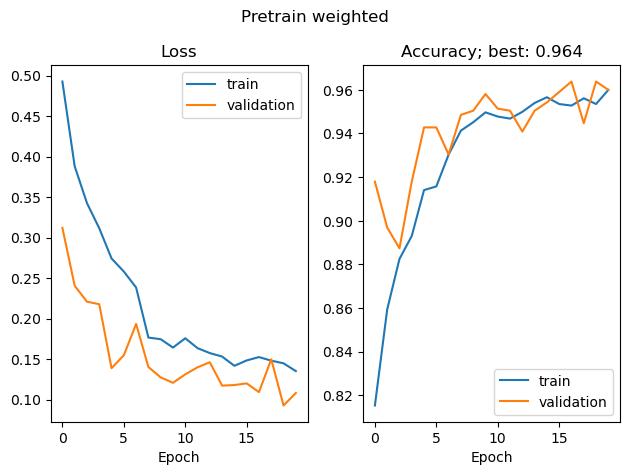

In [183]:
viz.plot_training_metrics(train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted, title="Pretrain weighted")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

In [49]:
# Save model
torch.save(model_ft_weighted.state_dict(), 'models/ft_weighted.pth')

#### Evaluate model on test set

In [33]:
# Load model
model_ft_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_weighted.fc.in_features
model_ft_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_ft_weighted.load_state_dict(torch.load('models/ft_weighted.pth'))

<All keys matched successfully>

In [53]:
y_true_ft_weighted, y_pred_ft_weighted, test_accuracy_ft_weighted, per_class_acc_ft_weighted = train.evaluate_model_on_test_set(model_ft_weighted, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 80.8 %
Accuracy for class: PNEUMONIA is 99.5 %
Overall accuracy (Pretrain weighted): 92.5
Precision: 0.943
Recall: 0.901
F1 score: 0.916


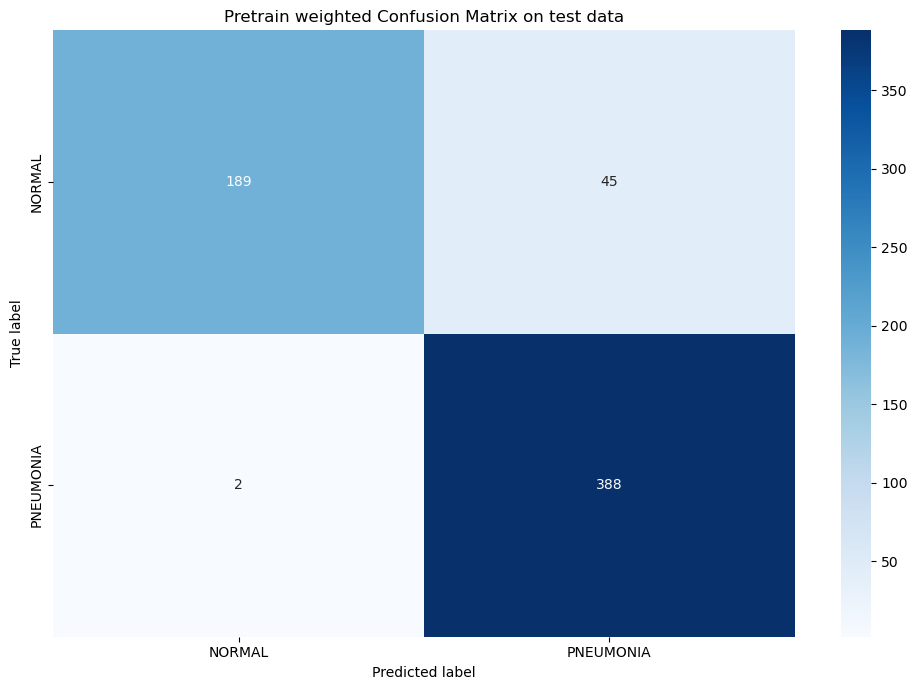

In [184]:
confusion_ft_weighted, precision_ft_weighted, recall_ft_weighted, fscore_ft_weighted, _ = train.compute_metrics_on_test_set(y_true_ft_weighted, y_pred_ft_weighted)
viz.show_test_summary_metrics(
    test_accuracy_ft_weighted, per_class_acc_ft_weighted, confusion_ft_weighted, precision_ft_weighted, recall_ft_weighted, fscore_ft_weighted,
    "Pretrain weighted", class_names)

### Pretrain: cutmix as data augmentation

In [89]:
model_ft_cutmix = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_cutmix.fc.in_features
model_ft_cutmix.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft_cutmix = optim.SGD(model_ft_cutmix.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft_cutmix = lr_scheduler.StepLR(optimizer_ft_cutmix, step_size=7, gamma=0.1)

In [90]:
model_ft_cutmix, hist_ft_cutmix = train.train_model(
    model_ft_cutmix, criterion, optimizer_ft_cutmix, exp_lr_scheduler_ft_cutmix,
    dataloaders, dataset_sizes, num_epochs=20, use_cutmix=True)

Epoch 1/20
----------
Phase:  train
train loss: 0.4821; acc: 0.8093
Phase:  val
val loss: 0.2011; acc: 0.9093

Epoch 2/20
----------
Phase:  train
train loss: 0.3938; acc: 0.8509
Phase:  val
val loss: 0.2096; acc: 0.9121

Epoch 3/20
----------
Phase:  train
train loss: 0.3796; acc: 0.8698
Phase:  val
val loss: 0.1658; acc: 0.9389

Epoch 4/20
----------
Phase:  train
train loss: 0.3325; acc: 0.8824
Phase:  val
val loss: 0.1641; acc: 0.9398

Epoch 5/20
----------
Phase:  train
train loss: 0.3078; acc: 0.8910
Phase:  val
val loss: 0.1775; acc: 0.9236

Epoch 6/20
----------
Phase:  train
train loss: 0.3138; acc: 0.8908
Phase:  val
val loss: 0.4964; acc: 0.7784

Epoch 7/20
----------
Phase:  train
train loss: 0.2963; acc: 0.8984
Phase:  val
val loss: 0.1479; acc: 0.9503

Epoch 8/20
----------
Phase:  train
train loss: 0.2411; acc: 0.9176
Phase:  val
val loss: 0.1315; acc: 0.9599

Epoch 9/20
----------
Phase:  train
train loss: 0.2400; acc: 0.9157
Phase:  val
val loss: 0.1237; acc: 0.9580

E

#### Save metrics

In [91]:
train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix = hist_ft_cutmix
train.save_training_metrics("metrics/ft_cutmix", train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix)

#### Analyze scratch cutmix model performance

In [94]:
train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix = train.load_training_metrics("metrics/ft_cutmix.npz")

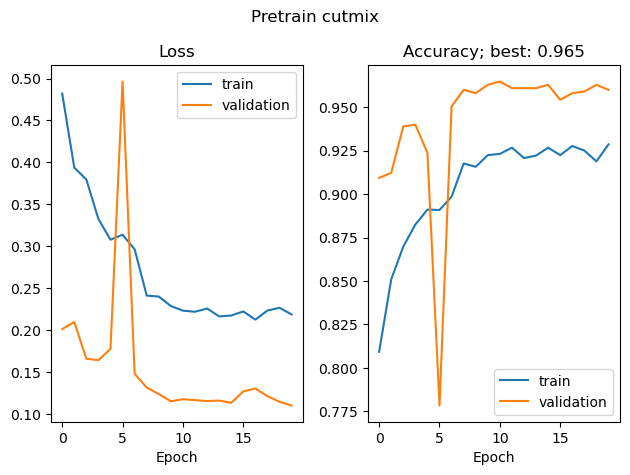

In [185]:
viz.plot_training_metrics(train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix, title="Pretrain cutmix")

Not sure why there was a spike in the loss/accuracy at epoch 5?

In [ ]:
# Save model
torch.save(model_ft_cutmix.state_dict(), 'models/ft_cutmix.pth')

#### Evaluate pretrained cutmix model on test set

In [34]:
# Load model
model_ft_cutmix = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_cutmix.fc.in_features
model_ft_cutmix.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_ft_cutmix.load_state_dict(torch.load('models/ft_cutmix.pth'))

<All keys matched successfully>

In [97]:
y_true_ft_cutmix, y_pred_ft_cutmix, test_accuracy_ft_cutmix, per_class_acc_ft_cutmix = train.evaluate_model_on_test_set(model_ft_cutmix, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 85.0 %
Accuracy for class: PNEUMONIA is 99.2 %
Overall accuracy (Pretrain cutmix): 93.9
Precision: 0.951
Recall: 0.921
F1 score: 0.933


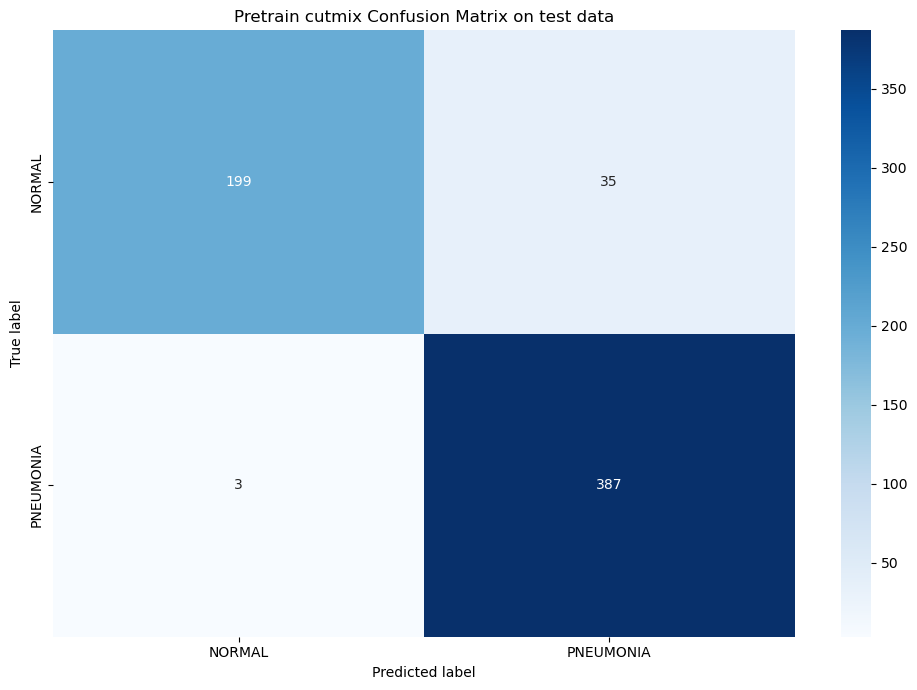

In [186]:
confusion_ft_cutmix, precision_ft_cutmix, recall_ft_cutmix, fscore_ft_cutmix, _ = train.compute_metrics_on_test_set(y_true_ft_cutmix, y_pred_ft_cutmix)
viz.show_test_summary_metrics(
    test_accuracy_ft_cutmix, per_class_acc_ft_cutmix, confusion_ft_cutmix, precision_ft_cutmix, recall_ft_cutmix, fscore_ft_cutmix,
    "Pretrain cutmix", class_names)

Seems like cutmix gives a huge improvement!

### Pretrain: cutmix and weighted loss

In [124]:
class_weights

tensor([0.7474, 0.2526], device='cuda:0')

In [125]:
model_ft_cutmix_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_cutmix_weighted.fc.in_features
model_ft_cutmix_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
# Observe that all parameters are being optimized
optimizer_ft_cutmix_weighted = optim.SGD(model_ft_cutmix_weighted.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft_cutmix_weighted = lr_scheduler.StepLR(optimizer_ft_cutmix_weighted, step_size=7, gamma=0.1)

In [126]:
model_ft_cutmix_weighted, hist_ft_cutmix_weighted = train.train_model(
    model_ft_cutmix_weighted, criterion_weighted, optimizer_ft_cutmix_weighted, exp_lr_scheduler_ft_cutmix_weighted,
    dataloaders, dataset_sizes, num_epochs=20, use_cutmix=True)

Epoch 1/20
----------
Phase:  train
train loss: 0.6546; acc: 0.7563
Phase:  val
val loss: 0.2549; acc: 0.9064

Epoch 2/20
----------
Phase:  train
train loss: 0.5028; acc: 0.8129
Phase:  val
val loss: 0.2491; acc: 0.9226

Epoch 3/20
----------
Phase:  train
train loss: 0.4485; acc: 0.8411
Phase:  val
val loss: 0.3247; acc: 0.8978

Epoch 4/20
----------
Phase:  train
train loss: 0.4450; acc: 0.8476
Phase:  val
val loss: 0.1803; acc: 0.9236

Epoch 5/20
----------
Phase:  train
train loss: 0.4309; acc: 0.8564
Phase:  val
val loss: 0.1800; acc: 0.9427

Epoch 6/20
----------
Phase:  train
train loss: 0.3635; acc: 0.8762
Phase:  val
val loss: 0.1722; acc: 0.9427

Epoch 7/20
----------
Phase:  train
train loss: 0.3511; acc: 0.8841
Phase:  val
val loss: 0.1630; acc: 0.9379

Epoch 8/20
----------
Phase:  train
train loss: 0.2821; acc: 0.9023
Phase:  val
val loss: 0.1509; acc: 0.9532

Epoch 9/20
----------
Phase:  train
train loss: 0.2674; acc: 0.9202
Phase:  val
val loss: 0.1468; acc: 0.9398

E

Save metrics

In [127]:
train_loss_ft_cutmix_weighted, train_acc_ft_cutmix_weighted, val_loss_ft_cutmix_weighted, val_acc_ft_cutmix_weighted = hist_ft_cutmix_weighted
train.save_training_metrics("metrics/ft_cutmix_weighted", train_loss_ft_cutmix_weighted, train_acc_ft_cutmix_weighted, val_loss_ft_cutmix_weighted, val_acc_ft_cutmix_weighted)

Save model

In [128]:
# Save model
torch.save(model_ft_cutmix_weighted.state_dict(), 'models/ft_cutmix_weighted.pth')

#### Analyze scratch cutmix model performance

In [129]:
train_loss_ft_cutmix_weighted, train_acc_ft_cutmix_weighted, val_loss_ft_cutmix_weighted, val_acc_ft_cutmix_weighted = train.load_training_metrics("metrics/ft_cutmix_weighted.npz")

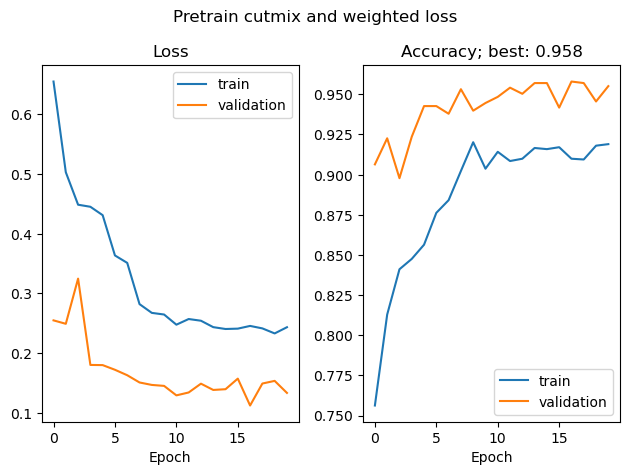

In [187]:
viz.plot_training_metrics(train_loss_ft_cutmix_weighted, train_acc_ft_cutmix_weighted, val_loss_ft_cutmix_weighted, val_acc_ft_cutmix_weighted, title="Pretrain cutmix and weighted loss")

Seems like the regularization helped, maybe could train for more epochs.

#### Evaluate model on test set

In [35]:
# Load model
model_ft_cutmix_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_cutmix_weighted.fc.in_features
model_ft_cutmix_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_ft_cutmix_weighted.load_state_dict(torch.load('models/ft_cutmix_weighted.pth'))

<All keys matched successfully>

In [132]:
y_true_ft_cutmix_weighted, y_pred_ft_cutmix_weighted, test_accuracy_ft_cutmix_weighted, per_class_acc_ft_cutmix_weighted = train.evaluate_model_on_test_set(model_ft_cutmix_weighted, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 87.2 %
Accuracy for class: PNEUMONIA is 99.0 %
Overall accuracy (Pretrain cutmix and weighted loss): 94.6
Precision: 0.954
Recall: 0.931
F1 score: 0.940


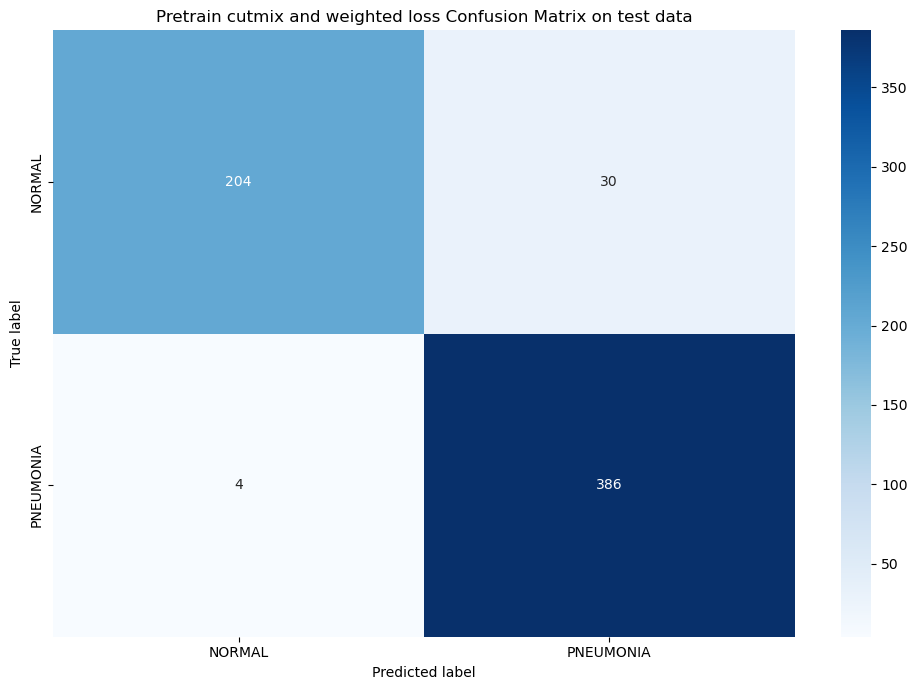

In [188]:
confusion_ft_cutmix_weighted, precision_ft_cutmix_weighted, recall_ft_cutmix_weighted, fscore_ft_cutmix_weighted, _ = train.compute_metrics_on_test_set(y_true_ft_cutmix_weighted, y_pred_ft_cutmix_weighted)
viz.show_test_summary_metrics(
    test_accuracy_ft_cutmix_weighted, per_class_acc_ft_cutmix_weighted, confusion_ft_cutmix_weighted, precision_ft_cutmix_weighted, recall_ft_cutmix_weighted, fscore_ft_cutmix_weighted,
    "Pretrain cutmix and weighted loss", class_names)

# Analysis

## Show some failure cases for each model

In [ ]:
import evaluate

In [ ]:
import torchvision.transforms as transforms

### Scratch models

#### Baseline

In [39]:
scratch_baseline_misclassified = evaluate.get_misclassified_images(model_scratch, dataloaders['test'])

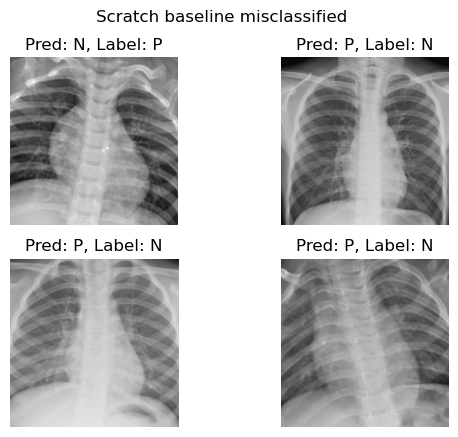

In [74]:
viz.show_misclassified_images(scratch_baseline_misclassified, class_names, mean, std, "Scratch baseline misclassified")

#### Weighted loss

In [57]:
scratch_weighted_misclassified = evaluate.get_misclassified_images(model_scratch_weighted, dataloaders['test'])

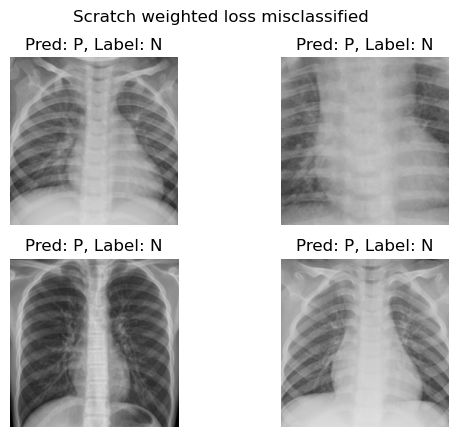

In [75]:
viz.show_misclassified_images(scratch_weighted_misclassified, class_names, mean, std, "Scratch weighted loss misclassified")

#### Cutmix

In [76]:
scratch_cutmix_misclassified = evaluate.get_misclassified_images(model_scratch_cutmix, dataloaders['test'])

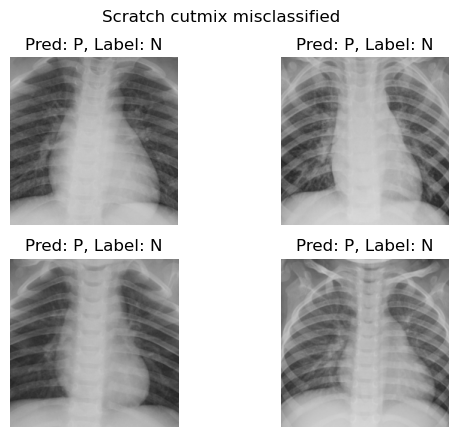

In [82]:
viz.show_misclassified_images(scratch_cutmix_misclassified, class_names, mean, std, "Scratch cutmix misclassified")

#### Cutmix and weighted loss

In [61]:
scratch_cutmix_weighted_misclassified = evaluate.get_misclassified_images(model_scratch_cutmix_weighted, dataloaders['test'])

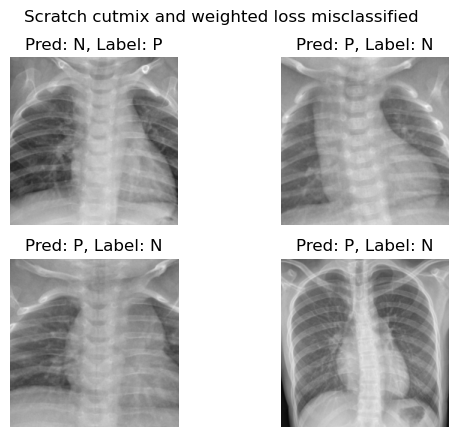

In [77]:
viz.show_misclassified_images(scratch_cutmix_weighted_misclassified, class_names, mean, std, "Scratch cutmix and weighted loss misclassified")

### Pretrained models

In [64]:
pretrain_baseline_misclassified = evaluate.get_misclassified_images(model_ft, dataloaders['test'])

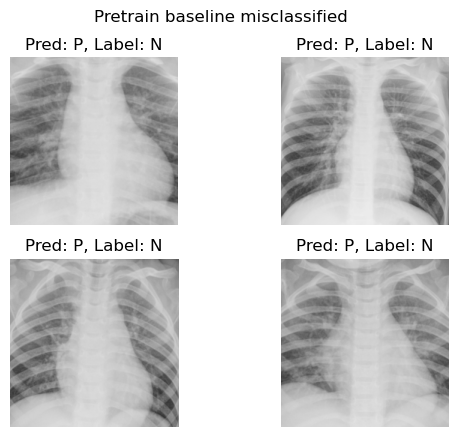

In [78]:
viz.show_misclassified_images(pretrain_baseline_misclassified, class_names, mean, std, "Pretrain baseline misclassified")

#### Weighted loss

In [66]:
pretrain_weighted_misclassified = evaluate.get_misclassified_images(model_ft_weighted, dataloaders['test'])

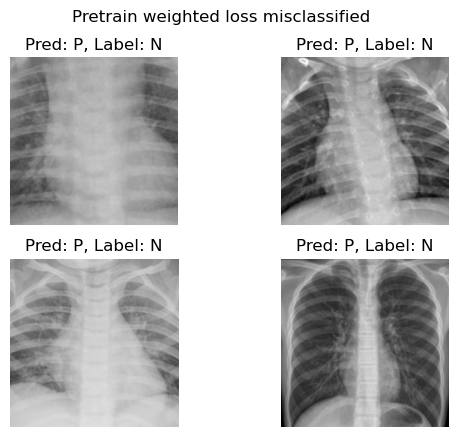

In [79]:
viz.show_misclassified_images(pretrain_weighted_misclassified, class_names, mean, std, "Pretrain weighted loss misclassified")

#### Cutmix

In [68]:
pretrain_cutmix_misclassified = evaluate.get_misclassified_images(model_ft_cutmix, dataloaders['test'])

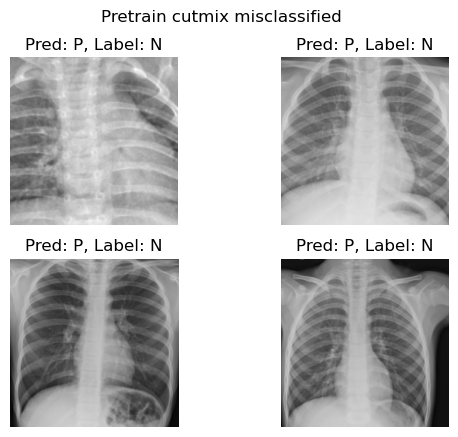

In [80]:
viz.show_misclassified_images(pretrain_cutmix_misclassified, class_names, mean, std, "Pretrain cutmix misclassified")

#### Cutmix and weighted loss

In [70]:
pretrain_cutmix_weighted_misclassified = evaluate.get_misclassified_images(model_ft_cutmix_weighted, dataloaders['test'])

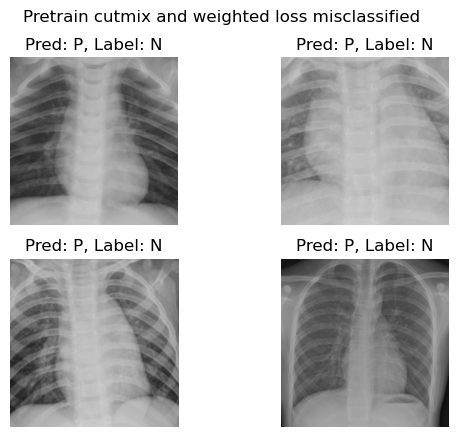

In [81]:
viz.show_misclassified_images(pretrain_cutmix_weighted_misclassified, class_names, mean, std, "Pretrain cutmix and weighted loss misclassified")

### Gradcam

In [86]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

In [100]:
model_scratch = model_scratch.to(device)
cam_extractor = SmoothGradCAMpp(model_scratch)

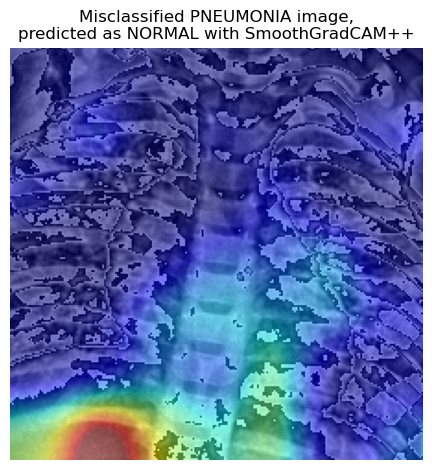

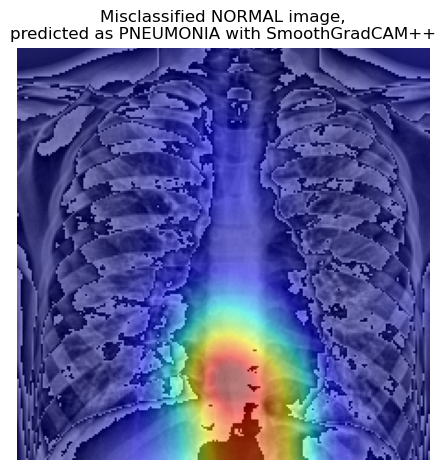

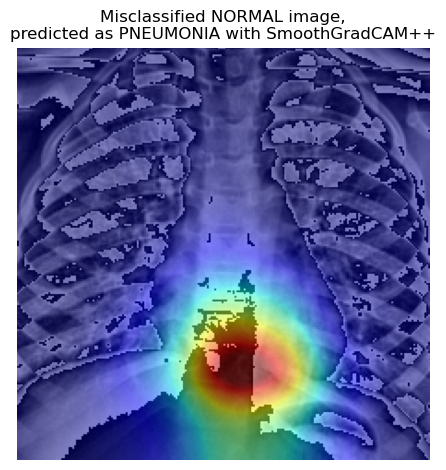

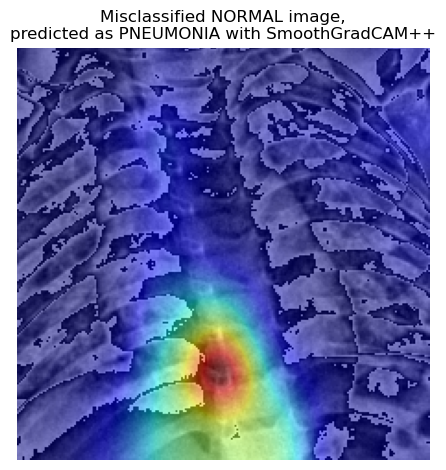

In [117]:
for img, label, pred in scratch_baseline_misclassified:
  # Preprocess your data and feed it to the model
  out = model_scratch(img.unsqueeze(0).to(device))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
  # Visualize the CAM
  # plt.imshow(activation_map[0].squeeze(0).cpu().numpy())

  # Resize the CAM and overlay it
  result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
  # Display it
  plt.title(f"Misclassified {class_names[label]} image,\npredicted as {class_names[pred]} with SmoothGradCAM++")
  plt.imshow(result); plt.axis('off'); plt.tight_layout()
  # Save image before showing
  plt.savefig(f"plots/scratch_baseline_misclassified_{label}_{pred}.png")
  plt.show()